In [1]:
Pkg.checkout("LowRankModels")
using LowRankModels, DataFrames, StatsBase, PyPlot

INFO: Checking out LowRankModels master...
INFO: Pulling LowRankModels latest master...
INFO: No packages to install, update or remove


In [2]:
import LowRankModels: evaluate, grad
evaluate(loss::Loss, X::Array{Float64,2}, w, y) = evaluate(loss, X*w, y)
grad(loss::Loss, X::Array{Float64,2}, w, y) = X'*grad(loss, X*w, y)


grad (generic function with 18 methods)

In [3]:
function proxgrad(loss::Loss, reg::Regularizer, X, y;
                  maxiters::Int = 10, stepsize::Number = 1., 
                  ch::ConvergenceHistory = ConvergenceHistory("proxgrad"))
    w = zeros(size(X,2))
    for t=1:maxiters
        t0 = time()
        # gradient step
        g = grad(loss, X, w, y)
        w = w - stepsize*g
        # prox step
        w = prox(reg, w, stepsize)
        # record objective value
        update_ch!(ch, time() - t0, obj = evaluate(loss, X, w, y) + evaluate(reg, w))
    end
    return w
end

proxgrad (generic function with 1 method)

# Model Methods

In [11]:
type Model
    target :: Symbol
    features :: Array{Symbol,1}
    #loss :: Any
    P :: Any
    loss::Loss
    reg::Regularizer
end

function get_X(model, data)
    t = model.target
    f = model.features
    X = zeros(size(data,1), length(f) - 1)
    index = 1
    for col in f
       if col != t
            X[:,index] = data[col]
            index += 1
       end
    end
    return X
end 

function get_y(model, data)
    t = model.target
    y = Array{Float64}(data[t])
    return y 
end 

function get_w(model,data)
    X = get_X(model,data) 
    y = Array{Bool}(get_y(model,data))
    L = model.loss
    R = model.reg
    #w = model.loss(X,y)
    w = proxgrad(L, R, X, y;  stepsize=1/(2*maximum(svdfact(X)[:S])^2), maxiters=50)
    return w
end

function avg_w(model,data
    ;resample_num = 1000)
    w_bs = 0
    n = size(data,1)
    for i in 1:resample_num
        #randomly samples from training set
        train_sample = data[sample(1:n,round(Int,.5*n)), :] 
        #incrememts bootstrap parameter by parameter of new sample
        w_bs = w_bs + get_w(model,data)
    end
    #finds average parameter among trials
    w_bs = w_bs / resample_num
    return w_bs
end 

function predict(model,train,test)
    w = get_w(model,train)
    X = get_X(model,test)
    #will be a function
    prediction = model.P(X,w)
    return prediction
end






predict (generic function with 1 method)

Notes: (1) Need to find a way to create a model that doesn't require regulizer (2) Boolean Loss functions don't work
(3) write a multi-class prediction function

### Prediction Space to Output Space Functions

In [5]:
function Boolean(X,w)
    val = sign(X*w)
    return val
end

function Real(X,w)
    val = X*w
    return val
end

function PosReal(X,w)
    val = max(X*w,0)
    return val
end

function Integer(X,w)
    val = round(X*w)
    return val
end

function PosInteger(X,w)
    val = max(round(X*w),0)
    return val
end


PosInteger (generic function with 1 method)

# Error/Validation Functions

In [6]:

function squared_bias(model,data;num_expectation = 1000)
    w_avg = avg_w(model,data)
    t = model.target
    f = model.features
    X = get_X(model,data)
    y = get_y(model,data)
    bias2 = 0
    for i in 1:num_expectation
        index = ceil(Int,rand()*size(X,1))
        row = (X[index,:])'
        pred_value = model.P(row,w_avg)[1]
        true_value = y[index]
        
        bias2 += ((true_value - pred_value))^2
    end
    return bias2/num_expectation
end



#need to make variance calculation faster/only reliable for real valued predictions
function variance_helper(x,model,data)
    w_avg = avg_w(model,data)
    num_samples = 100
    wMat = zeros(num_samples, length(w_avg))
    for i in 1:num_samples
        sample_data = data[sample(1:size(data,1),round(Int,.5*size(data,1))), :]
        w_dataset = get_w(model,sample_data)
        wMat[i,:] = w_dataset
    end
    return mean(((wMat .- transpose(w_avg)).^2)*x.^2)
end


function variance(model,data;num_expectation = 20)
    var = 0
    X = get_X(model,data)
    for i in 1:num_expectation
        row = X[ceil(Int,rand()*size(X,1)),:]
        var += variance_helper(row,model,data)
    end
    return var / num_expectation
end

function error_est(model,data)
    return squared_bias(model,data) + variance(model,data)
end



function bool_validate(model,train,test)
    pred_val = predict(model,train,test)
    true_val = get_y(model,test)

    n = length(pred_val)
    count = 0
    for i in 1:n
        if pred_val[i] != true_val[i]
            count +=1
        end
    end
    return (count/n)
end

function mse_validate(model,train,test)
    pred_val = predict(model,train,test)
    true_val = get_y(model,test)

    n = length(pred_val)
    
    err = mean((pred_val .- true_val).^2)
    return err
end



mse_validate (generic function with 1 method)

# Data Cleaning/Manipulation Functions

In [7]:
function one_hot_encode(data, target)
    columns = unique(data[target])
    n = size(data,1)
    new_cols = []
    for col in columns
        data[symbol(col)] = zeros(n)
        push!(new_cols, symbol(col))
    end
    for i in 1:n
        data[symbol(data[target][i])][i] = 1
    end
    delete!(data, target)
    return new_cols
end

function bool_outcome(data,target)
    columns = unique(data[target])
    n = size(data,1)
    new_cols = []
    for col in columns
        data[symbol(col)] = -1*ones(n)
        push!(new_cols, symbol(col))
    end
    for i in 1:n
        data[symbol(data[target][i])][i] = 1
    end
    delete!(data, target)
    return new_cols
end

#data comes from SPARCS
function clean(data)
    n = size(data,1)
    features = Symbol[]
    ohe_list = [:Health_Service_Area, :Age_Group, :Race, :Gender, :Payment_Typology_1, :Type_of_Admission]
    for feature in ohe_list
        new_feats = one_hot_encode(data,feature)
        append!(features,new_feats)
    end
    data[data[:Length_of_Stay] .== "120 +",:Length_of_Stay] = "120" #impute better
    data[:Length_of_Stay] = float(data[:Length_of_Stay])
    push!(features, :Length_of_Stay)
    data[:offset] = ones(n)
    push!(features, :offset)
    push!(features, :APR_Severity_of_Illness_Code)
    for i in 1:n
        if data[:Total_Charges][i][2:end] == "" #impute better
            val = "0"
        else 
            val = data[:Total_Charges][i][2:end]
        end
        data[:Total_Charges][i] = val
    end
    data[:Total_Charges] = float(data[:Total_Charges])
    push!(features, :Total_Charges)
    append!(features,bool_outcome(data,:Patient_Disposition))
    data = data[features]
    bad_features = [:Unknown, Symbol("Miscellaneous/Other"), Symbol("Not Available"), Symbol("Another Type Not Listed"), :Unknown_1]
    for bad in bad_features
        delete!(data, bad)
    end
    return data
end





#helper function for split_data
function build_subset(index,data)
    subset = similar(data,length(index))
    for i in 1:length(index)
        subset[i,:] = data[index[i],:]
    end
    return subset
end 

#splits dataset into train and test sets
#splits data based on the discharge identifier column :x (integer)
#split_raio = ratio of training set size to entire dataset size
function split_data(data_set;split_ratio = .8)
    n = size(data_set,1)
    split = Int(round(split_ratio*n))
    rand_index = shuffle([i for i in 1:n])
    train_index = rand_index[1:split]
    test_index = rand_index[split + 1:n]
    train = build_subset(train_index,data_set)
    test = build_subset(test_index,data_set)
    return(train,test)
end 


split_data (generic function with 1 method)

# Testing Space

In [8]:
heart_attack = readtable("heart_attack_clean.csv")
train,test = split_data(heart_attack)

(858×47 DataFrames.DataFrame
│ Row │ Western_NY │ Finger_Lakes │ Southern_Tier │ Central_NY │
├─────┼────────────┼──────────────┼───────────────┼────────────┤
│ 1   │ 1.0        │ 0.0          │ 0.0           │ 0.0        │
│ 2   │ 0.0        │ 0.0          │ 0.0           │ 0.0        │
│ 3   │ 0.0        │ 0.0          │ 0.0           │ 0.0        │
│ 4   │ 0.0        │ 0.0          │ 1.0           │ 0.0        │
│ 5   │ 0.0        │ 0.0          │ 0.0           │ 0.0        │
│ 6   │ 0.0        │ 0.0          │ 0.0           │ 0.0        │
│ 7   │ 1.0        │ 0.0          │ 0.0           │ 0.0        │
│ 8   │ 0.0        │ 1.0          │ 0.0           │ 0.0        │
│ 9   │ 0.0        │ 0.0          │ 0.0           │ 0.0        │
│ 10  │ 0.0        │ 0.0          │ 0.0           │ 0.0        │
│ 11  │ 0.0        │ 0.0          │ 0.0           │ 1.0        │
⋮
│ 847 │ 0.0        │ 0.0          │ 0.0           │ 0.0        │
│ 848 │ 0.0        │ 0.0          │ 0.0           │ 0.0    

In [12]:
target = :Expired
f1 = [:Expired,
    :Western_NY,:Finger_Lakes,:Southern_Tier,:Central_NY,:Capital_Adiron,:Hudson_Valley,:New_York_City,:Long_Island,
    :x70_or_Older,:x18_to_29,:x50_to_69,:x30_to_49,:x0_to_17,
    :White,:Black_African_American,:Other_Race,
    :M,
    :Medicare,:Self_Pay,:Blue_Cross_Blue_Shield,:Medicaid,:Private_Health_Insurance,:Managed_Care_Unspecified,:Federal_State_Local_VA,:Department_of_Corrections,
    :Emergency,:Urgent,:Elective,:Trauma,
    :APR_Severity_of_Illness_Code]

m1 = Model(target,f1,Boolean,LogisticLoss(),QuadReg())

Model(:Expired,Symbol[:Expired,:Western_NY,:Finger_Lakes,:Southern_Tier,:Central_NY,:Capital_Adiron,:Hudson_Valley,:New_York_City,:Long_Island,:x70_or_Older  …  :Medicaid,:Private_Health_Insurance,:Managed_Care_Unspecified,:Federal_State_Local_VA,:Department_of_Corrections,:Emergency,:Urgent,:Elective,:Trauma,:APR_Severity_of_Illness_Code],Boolean,LowRankModels.LogisticLoss(1.0,LowRankModels.BoolDomain()),LowRankModels.QuadReg(1.0))

In [ ]:
error_est(m2,train)

In [13]:
bool_validate(m1,train,test)

LoadError: LoadError: MethodError: no method matching grad(::LowRankModels.LogisticLoss, ::Float64, ::Float64)
Closest candidates are:
  grad(::LowRankModels.LogisticLoss, ::Float64, !Matched::Bool) at /home/juser/.julia/v0.5/LowRankModels/src/losses.jl:299
  grad(!Matched::LowRankModels.QuadLoss, ::Float64, ::Number) at /home/juser/.julia/v0.5/LowRankModels/src/losses.jl:139
  grad(!Matched::LowRankModels.L1Loss, ::Float64, ::Number) at /home/juser/.julia/v0.5/LowRankModels/src/losses.jl:153
  ...
while loading In[13], in expression starting on line 1

In [26]:
avg_error = 0
for i in 1:100
    train,test = split_data(heart_attack)
    avg_error += bool_validate(m1, train,test)
end
avg_error / 100

0.20906542056074767

In [23]:
depression = readtable("depression_clean.csv")
train1,test1 = split_data(depression)

(23524×53 DataFrames.DataFrame
│ Row   │ Western_NY │ Finger_Lakes │ Central_NY │ Southern_Tier │ x   │
├───────┼────────────┼──────────────┼────────────┼───────────────┼─────┤
│ 1     │ 0.0        │ 0.0          │ 1.0        │ 0.0           │ 0.0 │
│ 2     │ 0.0        │ 0.0          │ 0.0        │ 0.0           │ 0.0 │
│ 3     │ 0.0        │ 0.0          │ 0.0        │ 0.0           │ 0.0 │
│ 4     │ 0.0        │ 0.0          │ 0.0        │ 0.0           │ 0.0 │
│ 5     │ 0.0        │ 1.0          │ 0.0        │ 0.0           │ 0.0 │
│ 6     │ 0.0        │ 0.0          │ 0.0        │ 0.0           │ 0.0 │
│ 7     │ 0.0        │ 0.0          │ 0.0        │ 0.0           │ 0.0 │
│ 8     │ 0.0        │ 0.0          │ 0.0        │ 0.0           │ 0.0 │
│ 9     │ 0.0        │ 0.0          │ 0.0        │ 0.0           │ 0.0 │
│ 10    │ 0.0        │ 0.0          │ 0.0        │ 0.0           │ 0.0 │
│ 11    │ 0.0        │ 0.0          │ 0.0        │ 0.0           │ 0.0 │
⋮
│ 23513 │ 0.0     

In [31]:
print(names(depression))

Symbol[:Western_NY,:Finger_Lakes,:Central_NY,:Southern_Tier,:x,:Capital_Adiron,:Hudson_Valley,:New_York_City,:Long_Island,:x70_or_Older,:x30_to_49,:x50_to_69,:x18_to_29,:x0_to_17,:White,:Other_Race,:Black_African_American,:M,:F,:Medicare,:Medicaid,:Blue_Cross_Blue_Shield,:Private_Health_Insurance,:Self_Pay,:Federal_State_Local_VA,:Department_of_Corrections,:Managed_Care_Unspecified,:Elective,:Emergency,:Urgent,:Trauma,:Newborn,:Length_of_Stay,:offset,:APR_Severity_of_Illness_Code,:Total_Charges,:Skilled_Nursing_Home,:Home_or_Self_Care,:Cancer_Center_or_Children_s_Hospital,:Short_term_Hospital,:Court_Law_Enforcement,:Home_w_Home_Health_Services,:Psychiatric_Hospital_or_Unit_of_Hosp,:Left_Against_Medical_Advice,:Federal_Health_Care_Facility,:Inpatient_Rehabilitation_Facility,:Hospice_Medical_Facility,:Facility_w_Custodial_Supportive_Care,:Expired,:Hosp_Basd_Medicare_Approved_Swing_Bed,:Hospice_Home,:Medicare_Cert_Long_Term_Care_Hospital,:Critical_Access_Hospital]

In [24]:
target2 = :Length_of_Stay
f2 = [:Length_of_Stay,
    :Western_NY,:Finger_Lakes,:Central_NY,:Southern_Tier,:x,:Capital_Adiron,:Hudson_Valley,:New_York_City,:Long_Island,
    :x70_or_Older,:x30_to_49,:x50_to_69,:x18_to_29,:x0_to_17,
    :White,:Other_Race,:Black_African_American,
    :M,
    :Medicare,:Medicaid,:Blue_Cross_Blue_Shield,:Private_Health_Insurance,:Self_Pay,:Federal_State_Local_VA,
    :Department_of_Corrections,:Managed_Care_Unspecified,
    :Elective,:Emergency,:Urgent,:Trauma,
    :offset,
    :APR_Severity_of_Illness_Code]

m2 = Model(target2,f2,PosInteger,QuadLoss(),OneReg())


Model(:Length_of_Stay,Symbol[:Length_of_Stay,:Western_NY,:Finger_Lakes,:Central_NY,:Southern_Tier,:x,:Capital_Adiron,:Hudson_Valley,:New_York_City,:Long_Island  …  :Self_Pay,:Federal_State_Local_VA,:Department_of_Corrections,:Managed_Care_Unspecified,:Elective,:Emergency,:Urgent,:Trauma,:offset,:APR_Severity_of_Illness_Code],PosInteger,LowRankModels.QuadLoss(1.0,LowRankModels.RealDomain()),LowRankModels.OneReg(1.0))

In [31]:
error_est(m2,train1)

176.6942393684286

In [25]:
mse_validate(m2,train1,test1)

139.8660091821119

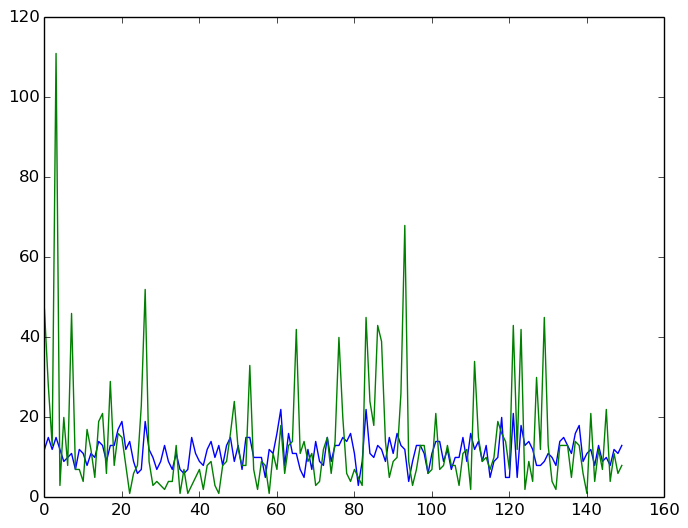

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f61b9247050>

In [27]:
plot(predict(m2,train1,test1)[1:150])
plot(test1[:Length_of_Stay][1:150])